<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="center" width="30%">

# Xarray 8: GRIB Data

## Overview

1. Explore the differences between GRIB and NetCDF formats
1. Work with GRIB output from the HRRR regional model
1. Visualize data that is non-global in extent

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| Xarray Lessons 1-7| Necessary | |

* **Time to learn**: 30 minutes
***

## Imports

In [1]:
import numpy as np
from datetime import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from metpy.plots import USCOUNTIES

## GRIB vs NetCDF formats

<span style="color:green">Advantages of GRIB</span>:
1. WMO-certifed format. Almost all NWP output that is generated by a national meteorological service will be in GRIB format.
2. Compresses well (GRIB version 2 only)
3. Still used for initial / boundary conditions in WRF.
4. "Well-behaved" GRIB data can be fairly easily translated into self-describing NetCDF format. A THREDDS server performs this translation on demand, thus presenting the user with data that looks to be in NetCDF format even if the actual data is in GRIB.

<span style="color:red">Disadvantages of GRIB</span>:
1. Not self-describing (unlike NetCDF). A GRIB data file must be accompanied by a set of tables that decodes fields into their actual physicall-relevant names. 
2. Despte being a WMO standard, there is no central source to maintain such tables. Often times, as new models get released, the existing tables that one might be using may not be updated with new parameters. Best strategy: update your GRIB software libraries often (and hope other things don't break as a result).
3. As tables change, there is no guarantee that a GRIB file you read one year might decode the same way another year.
4. Grids are written out sequentially to an output GRIB file. As a result, performing temporal and especially spatial subsetting, such as we can do in Xarray with NetCDF or Zarr data, is very difficult.

## Examine GRIB output from the HRRR regional model

We have downloaded a small subset of HRRR model output from the U. of Utah's HRRR Archive and placed it in `/spare11/atm533/data`. The data consists of analysis and 1-6 hour forecast output from the 1600 UTC run of the HRRR on 7 October 2020; a period when eastern New York experienced a derecho-like event, very unusual for the time of year.

Specify the date and time; convert from `datetime` format to `string`.

In [2]:
date = datetime(2020,10,7,16)
date

datetime.datetime(2020, 10, 7, 16, 0)

In [3]:
YYYYMMDDHH = date.strftime('%Y%m%d%H')
YYYYMMDDHH

'2020100716'

Set forecast hour and convert to a string; pad string with a leading 0 if < 10 (see https://stackoverflow.com/questions/39402795/how-to-pad-a-string-with-leading-zeros-in-python-3/39402910)

In [4]:
fhr = 4
fhrStr = f'{fhr:02}'
fhrStr

'04'

Open the GRIB2 files containing forecasted composite reflectivity data. We use Xarray's `cfgrib` engine to read in this type of data.
There is also a file containing u- and v- components of the wind at 10 and 80 m above ground level.

In [5]:
refcFile = '/spare11/atm533/data/' + YYYYMMDDHH + '_hrrr_REFC.grib2'
windFile = '/spare11/atm533/data/' + YYYYMMDDHH + '_hrrr_WIND.grib2'

In [6]:
refcFile

'/spare11/atm533/data/2020100716_hrrr_REFC.grib2'

In [7]:
ds = xr.open_dataset(refcFile,engine='cfgrib')

This is another Xarray Dataset, consisting of data variables (one in this case), coordinate variables, dimensions and attributes. 
However, the dimension names and coordinate variables look different than in ERA-5.

In [8]:
ds

<xarray.Dataset>
Dimensions:     (step: 7, y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 05:00:00 06:00:00
    atmosphere  float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  (step) datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    refc        (step, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-09-26T19:34 GRIB to CDM+CF via cfgrib-0.9.1...

We can create an Xarray `DataArray` object pointing to composite reflectivity just as we could for any other Xarray Data variable.

In [9]:
refc = ds.refc

In [10]:
refc

<xarray.DataArray 'refc' (step: 7, y: 1059, x: 1799)>
[13335987 values with dtype=float32]
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 05:00:00 06:00:00
    atmosphere  float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  (step) datetime64[ns] ...
Dimensions without coordinates: y, x
Attributes: (12/33)
    GRIB_paramId:                             260390
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1905141
    GRIB_typeOfLevel:                         atmosphere
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Maximum/Composite radar reflect...
    GRIB_shortName:                           refc
    GRIB_units:                               dB
    long_name:                                Maximum/Composite radar reflect...
    units:                                    dB
    standard_name:                            unknown

## Create a contour-fill plot of forecasted radar reflectivity

Our goal is produce a contour-fill plot of radar reflectivity, using colors that mimic similar NWS products. So first, create a colormap that includes RGB triplets in hex format, starting at 5 dBZ and going up to 75 dBZ.

Define a colormap to be used to contour the reflectivity values.

In [11]:
def radar_colormap():
    hrrr_reflectivity_colors = [
    "#00ecec", # 5
    "#01a0f6", # 10
    "#0000f6", # 15
    "#00ff00", # 20
    "#00c800", # 25
    "#009000", # 30
    "#ffff00", # 35
    "#e7c000", # 40
    "#ff9000", # 45
    "#ff0000", # 50
    "#d60000", # 55
    "#c00000", # 60
    "#ff00ff", # 65
    "#9955c9", # 70
    "#808080"  # 75
    ]
    cmap = colors.ListedColormap(hrrr_reflectivity_colors)
    return cmap

refl_range = np.arange(5,76,5) # defines our contour intervals
cmap= radar_colormap() # defines the color map that will accompany our filled contours and colorbar

Set areal extent for full (CONUS) region

In [12]:
latN = 52
latS = 20
lonW = -125
lonE = -60

Set the native projection from the Dataset's attributes.

In [13]:
lat1 = refc.attrs['GRIB_LaDInDegrees']
lon1 = refc.attrs['GRIB_LoVInDegrees']
slat1 = refc.attrs['GRIB_Latin1InDegrees']
slat2 = refc.attrs['GRIB_Latin2InDegrees']

print(lat1,lon1,slat1,slat2)
proj_data = ccrs.LambertConformal(central_longitude=lon1,
                             central_latitude=lat1,
                             standard_parallels=[slat1,slat2])

38.5 262.5 38.5 38.5


Set areal extent and projection for the subset (NY) region.

In [14]:
latN_sub = 45.2
latS_sub = 40.2
lonW_sub = -80.0
lonE_sub = -71.5
cLat_sub = (latN_sub + latS_sub)/2.
cLon_sub = (lonW_sub + lonE_sub )/2.

proj_sub = ccrs.LambertConformal(central_longitude=cLon_sub,
                             central_latitude=cLat_sub,
                             standard_parallels=[cLat_sub])

Remind ourselves of the dimensions. They do not resemble what we've seen in the ERA-5 datasets: instead of `time`, `longitude`, and `latitude`, we have `step`, `y`, and `x`. We can look at each one of them.

In [15]:
refc.dims 

('step', 'y', 'x')

In [16]:
refc.step

<xarray.DataArray 'step' (step: 7)>
array([             0,  3600000000000,  7200000000000, 10800000000000,
       14400000000000, 18000000000000, 21600000000000], dtype='timedelta64[ns]')
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 05:00:00 06:00:00
    atmosphere  float64 ...
    valid_time  (step) datetime64[ns] ...
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [17]:
refc.y

<xarray.DataArray 'y' (y: 1059)>
array([   0,    1,    2, ..., 1056, 1057, 1058])
Coordinates:
    time        datetime64[ns] ...
    atmosphere  float64 ...
Dimensions without coordinates: y

In [18]:
refc.x

<xarray.DataArray 'x' (x: 1799)>
array([   0,    1,    2, ..., 1796, 1797, 1798])
Coordinates:
    time        datetime64[ns] ...
    atmosphere  float64 ...
Dimensions without coordinates: x

We can see that these dimensions are just sequential index values for x and y, while the time steps are one hour at a time, expressed in nanoseconds. This makes it more difficult for us to use Xarray's handy way of using dimension names for, among other things, selection and subsetting. Instead, we have to use a more NumPy/Pandas-way of using index numbers.

Here, we will pick one of the seven discrete times to display radar imagery. Let's choose index 4 ... valid at 2000 UTC 7 October ... just as the squall line was impacting the Greater Capital District.

Select timestep index. Use it to not only plot the correct reflectivity array, but also to determine the date and time for the purposes of labeling. Note the three-step process:

In [19]:
idx = 4

1. Get the time as a NumPy Datetime64 object:

In [20]:
validTime = refc.valid_time[idx].values

In [21]:
validTime

numpy.datetime64('2020-10-07T20:00:00.000000000')

2. Convert into a Pandas `Timestamp` object:

In [22]:
validTime = pd.Timestamp(validTime) # Converts validTime to a Pandas Timestamp object

In [23]:
validTime

Timestamp('2020-10-07 20:00:00')

3. Use the `datetime` library's `strftime` method to create a time string object:

In [24]:
timeStr = validTime.strftime("%Y-%m-%d %H%M UTC") # We can now use Datetime's strftime method to create a time string.

In [25]:
timeStr

'2020-10-07 2000 UTC'

## Make the map

In [26]:
tl1 = "HRRR Composite Reflectivity (dBZ)"
tl2 = str('Valid at: '+ timeStr)
title_line = (tl1 + '\n' + tl2 + '\n')

First draw a radar map that covers the entire domain of the HRRR.

<div class="alert alert-warning">
    <b>Warning:</b> The HRRR stands for <i>High Resolution Rapid Refresh</i>. The horizontal dimensions are 1059 x 1799 ... approximately 3 km between gridpoints. As a result, the maps will take longer to render.</div>

<div class="alert alert-info">
    <b>Tip:</b> Omitting some of the cartographic features, especially the filled ones like *ocean*, *land*, and *lakes*, will speed things up.</div>

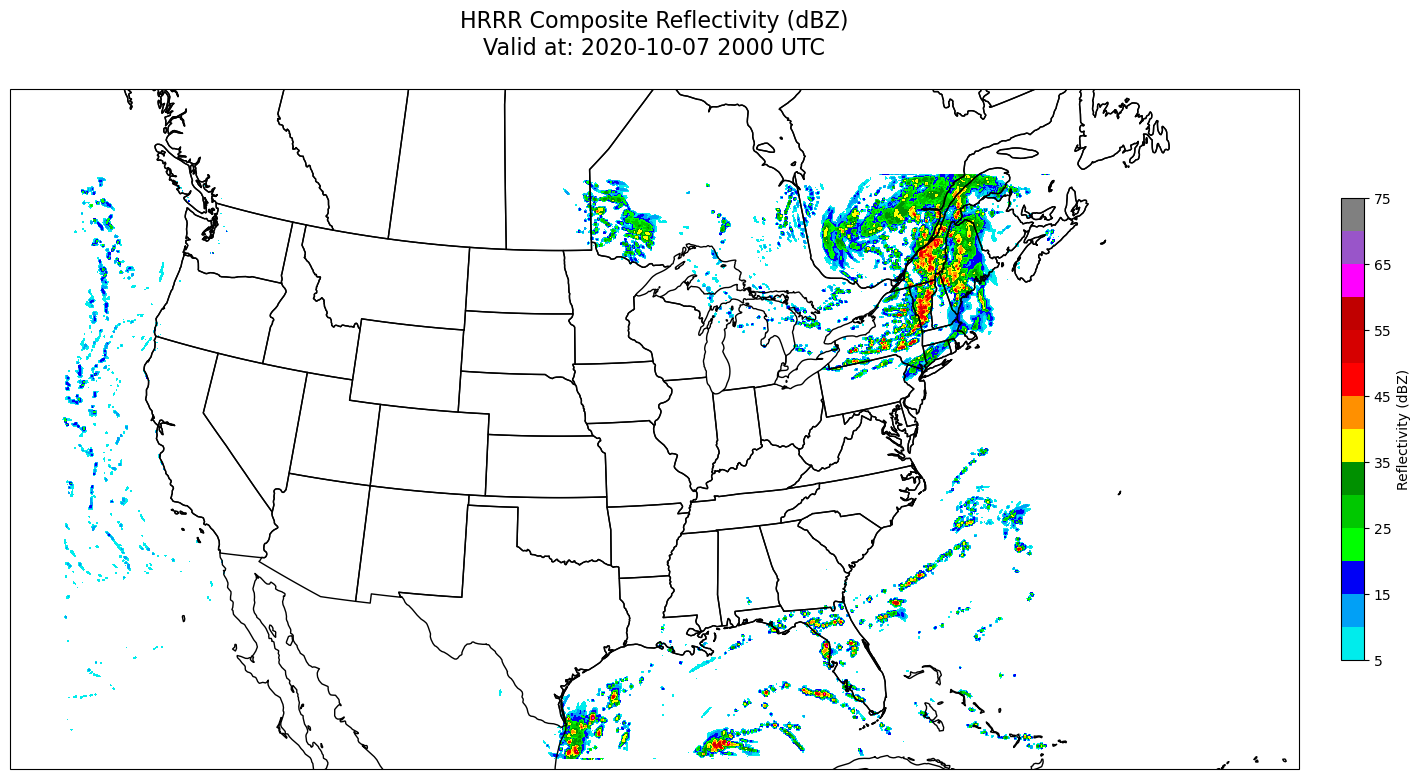

In [27]:
res = '50m'
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=proj_data)
ax.set_extent((lonW,lonE,latS,latN))
#ax.add_feature (cfeat.LAND.with_scale(res))
#ax.add_feature (cfeat.OCEAN.with_scale(res))
ax.add_feature(cfeat.COASTLINE.with_scale(res))
#ax.add_feature (cfeat.LAKES.with_scale(res), alpha = 0.5)
ax.add_feature (cfeat.STATES.with_scale(res))
# don't include county lines here
#ax.add_feature(USCOUNTIES,edgecolor='grey', linewidth=1, zorder = 3 );
CF = ax.contourf(refc.longitude,refc.latitude,refc[idx],levels=refl_range,cmap=cmap,transform=ccrs.PlateCarree())
cbar = plt.colorbar(CF,fraction=0.046, pad=0.03,shrink=0.5)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel("Reflectivity (dBZ)",fontsize=10)
title = ax.set_title(title_line,fontsize=16)

Now, plot the map over NYS.

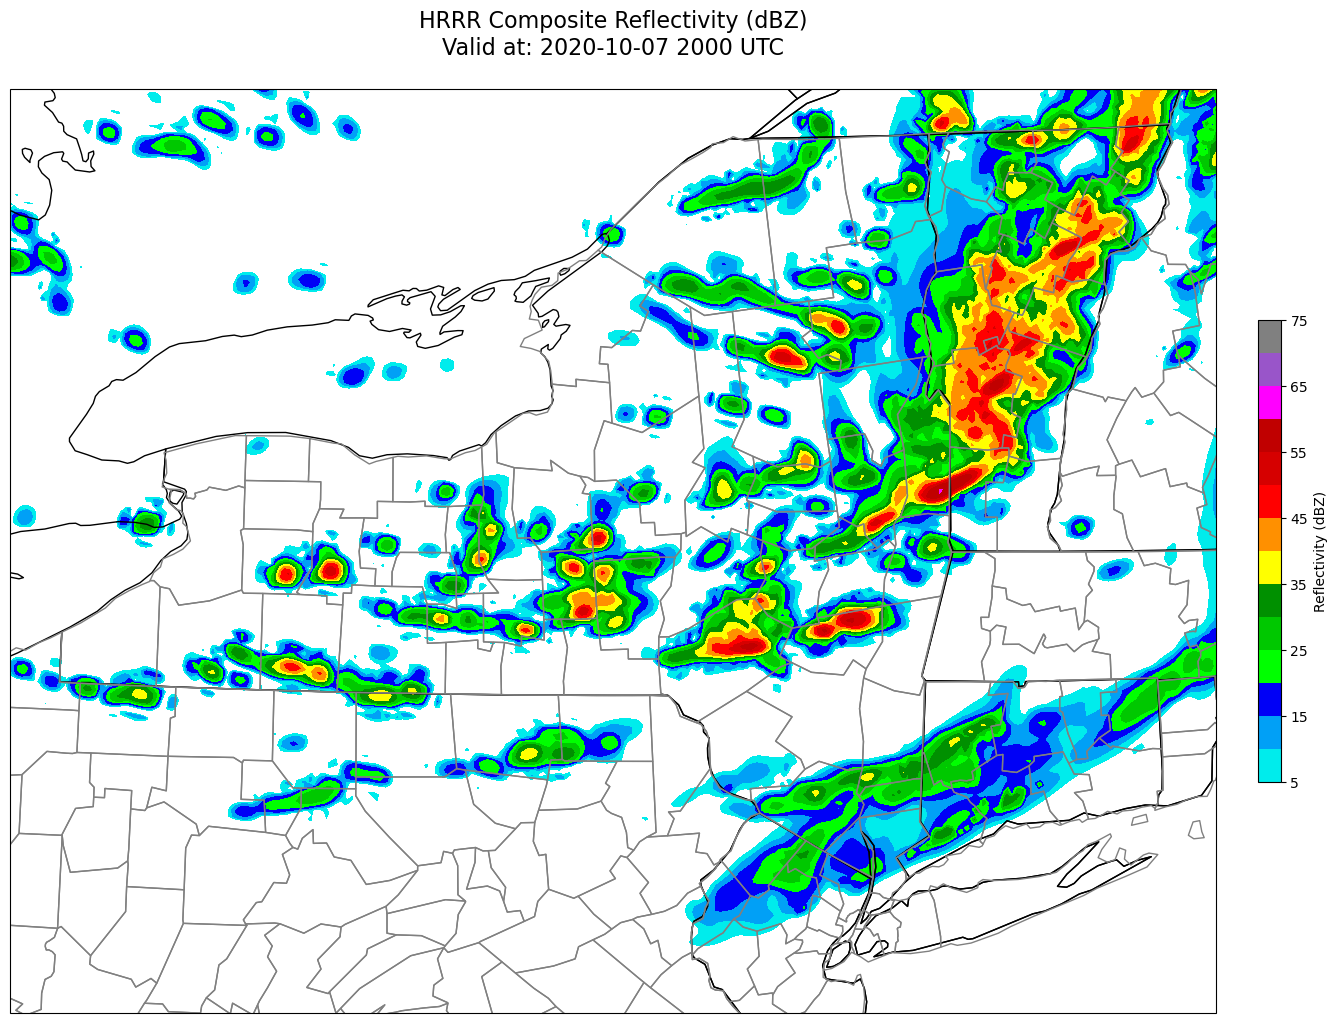

In [28]:
res = '50m'
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=proj_sub)
ax.set_extent((lonW_sub,lonE_sub,latS_sub,latN_sub),crs=ccrs.PlateCarree())
#ax.add_feature (cfeat.LAND.with_scale(res))
#ax.add_feature (cfeat.OCEAN.with_scale(res))
ax.add_feature(cfeat.COASTLINE.with_scale(res))
#ax.add_feature (cfeat.LAKES.with_scale(res), alpha = 0.5)
ax.add_feature (cfeat.STATES.with_scale(res))
ax.add_feature(USCOUNTIES,edgecolor='grey', linewidth=1 );
CF = ax.contourf(refc.longitude,refc.latitude,refc[idx],levels=refl_range,cmap=cmap,transform=ccrs.PlateCarree())
cbar = plt.colorbar(CF,fraction=0.046, pad=0.03,shrink=0.5)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel("Reflectivity (dBZ)",fontsize=10)
title = ax.set_title(title_line,fontsize=16)

<div class="alert alert-warning">
    <b>To think about:</b><br>
    1. How would you plot different times? Is there just a single cell whose value needs to be change?<br>
    2. What if you wanted to loop over all seven times? Why does a Jupyter notebook make it a bit more difficult to do this?<br>
    3. Try loading and plotting the WIND Dataset. It consists of u- and v- components of wind at 10 and 80 m. Can you use the same call to xarray.open_dataset that you did for reflectivity?
    </div>

---
## Summary
* Using Xarray's `cfgrib` data engine, we can analyze and display data in **GRIB** format.
* In general, **GRIB** data is "messier" than data in a self-describing format, such as **NetCDF**.

### What's Next?
In the next notebook, we'll explore HRRR data that is stored "in the cloud", in a format called *Zarr*.

## Resources and References
1. [GRIB Reference](https://en.wikipedia.org/wiki/GRIB)
1. [MetPy Monday Episode 135: Reading GRIB](https://www.youtube.com/watch?v=yLoudFv3hAY&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=126&ab_channel=Unidata)
2. [MetPy Monday Episode 136: Delving into unknown NDFD GRIB data](https://www.youtube.com/watch?v=kEhcJP3G0xw&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=127&ab_channel=Unidata)
3. [MetPy Monday Episode 137: Finding GRIB forecast times and attaching units](https://www.youtube.com/watch?v=-OuSnA9f9qg&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=128&ab_channel=Unidata)
